# SARIMA forecast

## 01 - Background

Our goal in this challenge is to apply the basic concepts of time series analysis on one-dimension data (sales depending on the date).

In this challenge, we'll go through the following steps : 
1. load and visualize the data;
2. train our models and make predictions;
3. use an econometric approach to model the serie and be able to forecast it;
4. use machine learning to hack this modelization.

The dataset is the csv

## 02 - Load Data and Plot Time Series
Let's start by loading the time series of the challenge and plot the time series

In [19]:
import pandas as pd

data = pd.read_csv('data/monthly_champagne_sales.csv')
data

,"Month,""Sales"""
1964-01,2815
1964-02,2672
1964-03,2755
1964-04,2721
1964-05,2946
...,...
1972-05,4618
1972-06,5312
1972-07,4298
1972-08,1413


👉 Convert dataframe with datetime objects as index to make it look like this
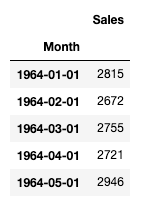

In [20]:
from datetime import datetime

print(data.columns)

Index(['Month,"Sales"'], dtype='object')


In [23]:
data = data.rename(columns={'Month,"Sales"': 'Sales'})
data.index = pd.to_datetime(data.index, format='%Y-%m')
data = data.rename_axis('Month')
data

,Sales
Month,
1964-01-01,2815
1964-02-01,2672
1964-03-01,2755
1964-04-01,2721
1964-05-01,2946
...,...
1972-05-01,4618
1972-06-01,5312
1972-07-01,4298


## 04 - Visualize and interpet the data

Well done, thanks to this "reindexing", you should now be able to plot the "Sales" (y-axis) as a function of the time (x-axis) easily

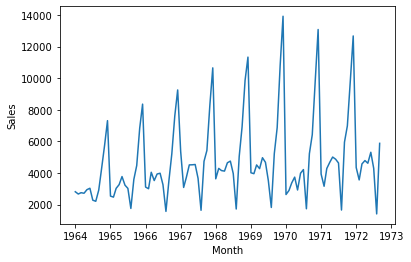

In [26]:
import matplotlib.pyplot as plt

plt.plot(data.index, data['Sales'])
plt.xlabel('Month')
plt.ylabel('Sales')
plt.show()

If your code is correct, you should be able to see that this Time Serie (TS) is:
- Not stationary (mean and variance are not constant).
- Exhibits strong seasonality.
- Seems to have a trend.

Let's see a decomposition of the data between **trend**, **saisonality** and **noise**. In order to do that, you have to make use of statsmodels [`seasonal_decompose`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). Read the docs and make sure you understand what this function is doing and how to use it. Then:
1. plot the "Sales" with an "additive" model
2. plot the "Sales" with a "multiplicative" model

Pro tips: end your statsmodels plot method calls with a `;` to avoid double-plotting issues

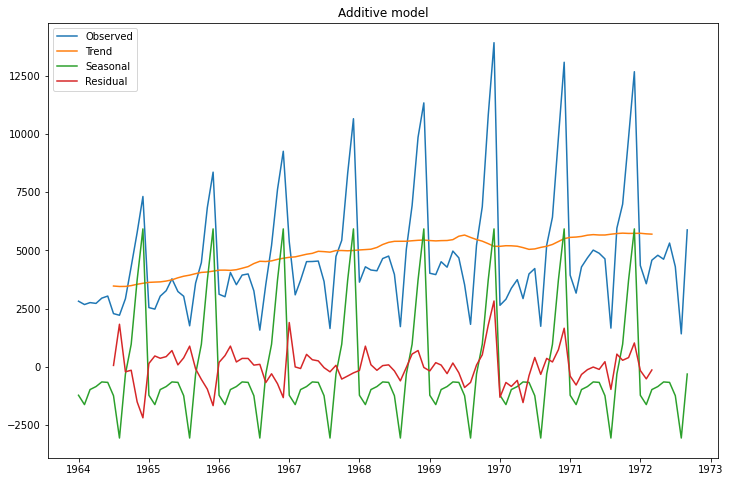

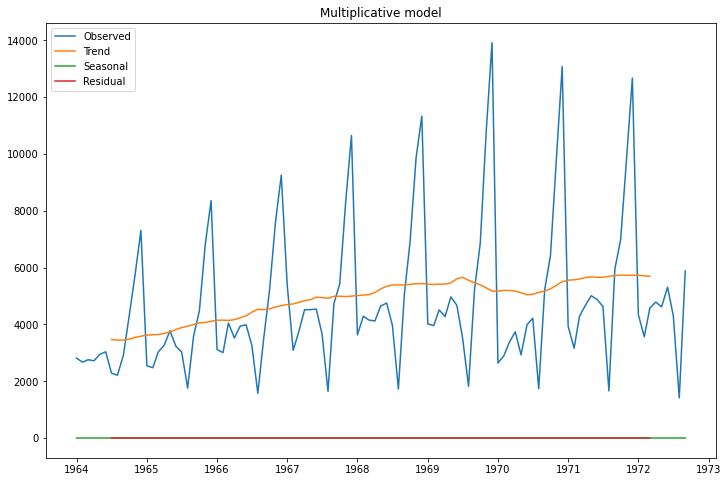

In [29]:
import statsmodels.api as sm

result_add = sm.tsa.seasonal_decompose(data['Sales'], model='additive')
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Additive model')
ax.plot(result_add.observed, label='Observed')
ax.plot(result_add.trend, label='Trend')
ax.plot(result_add.seasonal, label='Seasonal')
ax.plot(result_add.resid, label='Residual')
ax.legend()
plt.show();

result_mul = sm.tsa.seasonal_decompose(data['Sales'], model='multiplicative')
fig, ax = plt.subplots(figsize=(12, 8))
ax.set_title('Multiplicative model')
ax.plot(result_mul.observed, label='Observed')
ax.plot(result_mul.trend, label='Trend')
ax.plot(result_mul.seasonal, label='Seasonal')
ax.plot(result_mul.resid, label='Residual')
ax.legend()
plt.show();

👉 De-seasonalize this time serie using the decomposition of your choice

In [30]:
result_add = sm.tsa.seasonal_decompose(data['Sales'], model='additive')
de_seasonalized = data['Sales'] - result_add.seasonal

☝️ We could fit an ARIMA model on a "de-seasonalized" version of this time serie, and then re-compose it back after our forecast. But in this challenge, we will use SARIMA models to _directly_ fit the original time serie!

## 05 - Split the data (train/test)


For time series, we cannot randomly sample points to be in the test set. The test set needs to be "out-of-time", that is, strictly in the future of the test set. For the purpose of this exercise, we will use data up to 1970 for training and after for the test.

👉 create `df_train` and `df_test`, splitting the DataFrame before 1970 for the training and after (or equal to) for the testing

In [31]:
threshold_date = pd.to_datetime('1970-01-01')
data_train = data[data.index < threshold_date]
data_test = data[data.index >= threshold_date]

## 06 - SARIMA
We will analyse the data using a SARIMA model (Seasonal Auto Regressive Integrated Moving Average).


We need to :
- find how to stationarize the time serie (I in SARIMA)
- find the auto-regressive (AR) part
- find the Moving-Average (MA) part
- find the seasonality (S)

### Step 1: Check stationarity

If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast.

A quick glance at the plot above should be sufficient to convince you that the time serie is not stationary.

Double check the stationarity of `df["Sales"]` using the [`Augmented Dick Fuller test`](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html) and especially its p-value

In [32]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['Sales'])

adf_statistic = adf_result[0]
p_value = adf_result[1]

In [33]:
print(adf_statistic)
print(p_value)

if p_value < 0.05:
    print('Cette série est stationnaire')
else:
    print("Cette série n'est pas stationnaire")

-1.8335930563276297
0.3639157716602417
Cette série n'est pas stationnaire


The p-value should be less than 0.05 to have a 95% confidence in the stationarity.  

If the p-value is larger than 0.05, we cannot reject the null hypothesis (null hypothesis = "the process is not stationary").

Ideally, p is *much* smaller than 0.05.

Another way to look for stationarity, is to look at the autocorrelation function (ACF).

Plot the ACF of the time series. You should see a large peak at lag 12, indicating strong yearly seasonality.

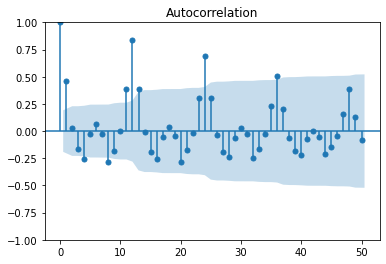

In [44]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data['Sales'], lags=50);

### Step 2 - Seasonal differencing (D)

We have a strong seasonality with a period of 12 months.

Do a **seasonal differencing of lag 12** on the time series, and plot the differenced data and check the ACF plot (+ADF test) again.

Don't forget to drop NaN's.

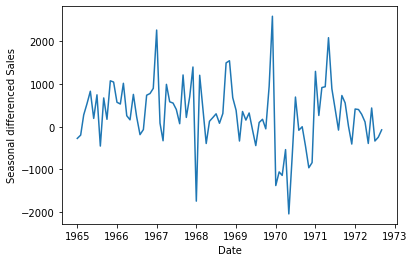

In [45]:
seasonal_diff = data['Sales'].diff(periods=12).dropna()

plt.plot(seasonal_diff)
plt.xlabel('Date')
plt.ylabel('Seasonal differenced Sales')
plt.show()

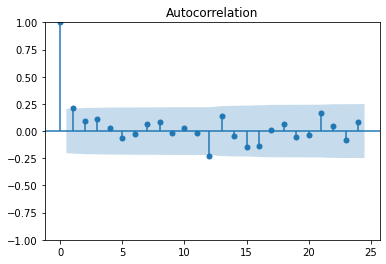

In [46]:
plot_acf(seasonal_diff, lags=24)
adf_result = adfuller(seasonal_diff)
adf_statistic = adf_result[0]
p_value = adf_result[1]

☝️ One single seasonal differencing seems enough to stationarize the TS.  
D=1 (1 seasonal diff) and m=12 (seasonality = 12) for SARIMA(p,d,q, P,D,Q,m)

### Step 3 - Differencing (d)

If the time series is still not stationary, it needs to be stationarized through *differencing*. It means that we take the difference between each value and the preceding one (*first difference*).

Do we need further differencing after removing the seasonality?

Check the ACF and ADF after running an additional first order diff(1) on your diff(12) series.

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


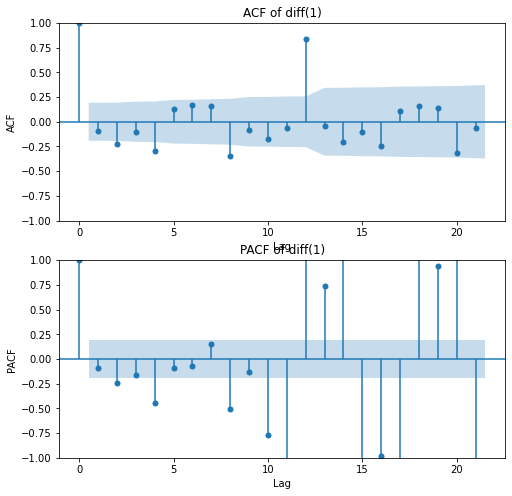

ADF statistic: -7.189896
p-value: 0.000000
critical values:
	1%: -3.504
	5%: -2.894
	10%: -2.584


In [48]:
diff_1 = data.diff(periods=1).dropna()

fig, ax = plt.subplots(2,1, figsize=(8,8))
plot_acf(diff_1, ax=ax[0])
ax[0].set(title='ACF of diff(1)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')

plot_pacf(diff_1, ax=ax[1])
ax[1].set(title='PACF of diff(1)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')

plt.show()

result = adfuller(diff_1)
print('ADF statistic: %f'% result[0])
print('p-value: %f'% result[1])
print('critical values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


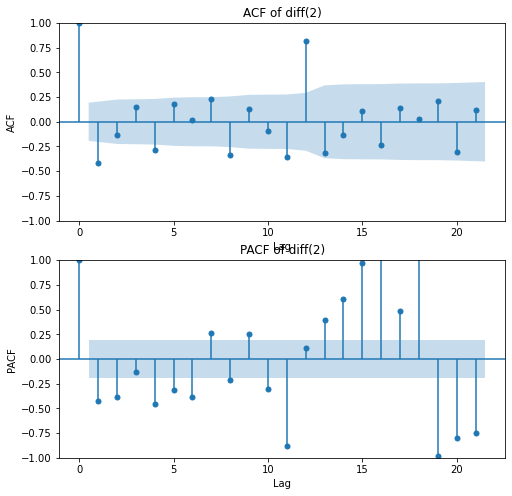

ADF Statistic: -7.924775
p-value: 0.000000
Critical Values:
	1%: -3.506
	5%: -2.895
	10%: -2.584


In [51]:
diff_2 = diff_1.diff(periods=1).dropna()

fig, ax = plt.subplots(2,1, figsize=(8,8))
plot_acf(diff_2, ax=ax[0])
ax[0].set(title='ACF of diff(2)')
ax[0].set_xlabel('Lag')
ax[0].set_ylabel('ACF')

plot_pacf(diff_2, ax=ax[1])
ax[1].set(title='PACF of diff(2)')
ax[1].set_xlabel('Lag')
ax[1].set_ylabel('PACF')

plt.show()

result = adfuller(diff_2)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

👉 Additional differencing actually made both the p-value and the ACF look worse! 
We can select (d=0) and (D=1)

### Step 4 - Select AR(p,P) and MA(q,Q) terms

You will now use the ACF and PACF plots to decide whether to include an AR term(s), MA term(s), or both.





- The autocorrelation plot ([`plot_acf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_acf.html)) applied to your **fully differentiated** series allows you to select MA number (`q`)
- MA($\color{blue}{q}$) = number of lag beyond which the $\color{blue}{ACF}$ of  $Y^{\color{green}{(d+D)}}$ cuts off


- The partial autocorrelation plot [`plot_pacf`](https://www.statsmodels.org/stable/generated/statsmodels.graphics.tsaplots.plot_pacf.html) applied to your **fully differentiated** series allows you to select AR (`p`)
- AR($\color{red}{p}$) = number of lags beyond which the $\color{red}{PACF}$ of $Y^{\color{green}{(d+D)}}$  cuts off

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


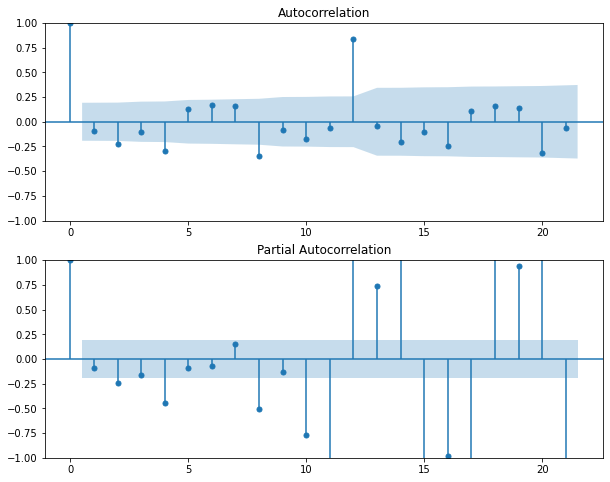

In [53]:
diff = data.diff().dropna()

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,8))
plot_acf(diff, ax=ax[0])
plot_pacf(diff, ax=ax[1])
plt.show()

☝️ It seems like there are no significant peaks in either ACF or PACF, so most likely p=q=0.  
Our first guess for SARIMA is therefore d=0, p=q=0, D=1 and m=12.  

How to find values for P and Q? Here, we will let pdarima try values 1 and 0 for P and Q with a grid_search for us.
If you really want to find these coefficient by yourself, [Read here 🤯 ](https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima) for some rules of thumb

👉 Run [auto_arima](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html) for the training set. set seasonal=True, m=12 and D=1. Search for p and q, P and Q from 0 to 2. Then, print the summary of the model with model.summary().
Use `njobs=-1, trace=True, error_action='ignore', suppress_warnings=True`

In [61]:
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

kpss_diffs = ndiffs(data, alpha=0.05, test='kpss', max_d=6)
adf_diffs = ndiffs(data, alpha=0.05, test='adf', max_d=6)
n_diffs = max(adf_diffs, kpss_diffs)

seasonal_diffs = 1
seasonal_period = 12
if n_diffs == 0:
    ts_diff = data.diff(seasonal_period).dropna()
else:
    ts_diff = data.diff().diff(seasonal_period).dropna()

model = pm.auto_arima(diff, seasonal=True, m=seasonal_period, D=seasonal_diffs, 
                      start_p=0, start_q=0, max_p=2, max_q=2, 
                      information_criterion='aic', trace=True,
                      error_action='ignore', suppress_warnings=True,
                      n_jobs=-1)
print(model.summary())

C:\Users\utilisateur\anaconda3\lib\site-packages\pmdarima\arima\_validation.py:76: UserWarning: stepwise model cannot be fit in parallel (n_jobs=1). Falling back to stepwise parameter search.
  warnings.warn('stepwise model cannot be fit in parallel (n_jobs=%i). '


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=1518.551, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=1526.661, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=1506.848, Time=0.12 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=1524.662, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=1511.610, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=1508.254, Time=0.84 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=1508.759, Time=0.25 sec
 ARIMA(1,0,0)(0,1,1)[12] intercept   : AIC=1507.183, Time=0.28 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=1510.222, Time=1.41 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=1516.671, Time=0.20 sec
 ARIMA(2,0,0)(1,1,0)[12] intercept   : AIC=1499.558, Time=0.14 sec
 ARIMA(2,0,0)(0,1,0)[12] intercept   : AIC=1502.702, Time=0.14 sec
 ARIMA(2,0,0)(2,1,0)[12] intercept   : AIC=1501.005, Time=0.89 sec
 ARIMA(2,0,0)(1,1,1)[12]

The best model found is `ARIMA(0,0,0)(0,1,0)[12]` ! 
This means that the Time Serie condidered does not justify adding any "autoregressive" nor "moving average" modelling beyond simple "seasonal differencing".

Such "poor" model is only likely to predict a repetition of the last seasonal pattern detected, alongwith the prolongation of the mean increasing trend. Let's check it out

👉 Use `model.predict` with `n_periods` = length of the test set, in order to save the following three predictions
- `central`
- `upper`
- `lower`

Save them as Pandas Series, and index them by the same index than your `y_test`

In [74]:
import statsmodels.api as sm

train_size = int(0.8 * len(data))
train_data = data.iloc[:train_size]
test_data = data.iloc[train_size:]

model = sm.tsa.ARIMA(train_data['Sales'], order=(1,1,1))
model_fit = model.fit()

forecast = model_fit.forecast(len(test_data))

if isinstance(forecast, tuple):
    central_pred = forecast[0]
    upper_pred = forecast[2][:,0]
    lower_pred = forecast[2][:,1]
else:
    central_pred = forecast
    upper_pred = forecast
    lower_pred = forecast

central_pred = pd.Series(central_pred, index=test_data.index)
upper_pred = pd.Series(upper_pred, index=test_data.index)
lower_pred = pd.Series(lower_pred, index=test_data.index)

C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\utilisateur\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


👇 Run the cell below to plot your predictions against reality

NameError: name 'central' is not defined

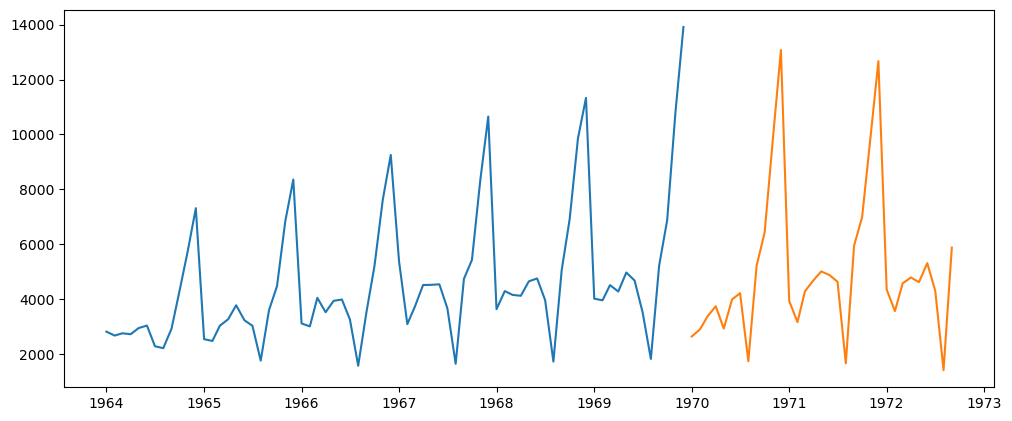

In [76]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(data_train, label = "train values")
plt.plot(data_test, label = "true test values")
plt.plot(central, color='darkgreen',label = "forecast")
plt.fill_between(lower.index, 
                 lower, 
                 upper, 
                 color='k', alpha=.15)

plt.title("SARIMA Forecast")
plt.legend()
plt.show()

👉 Try to assign non-null values to  `p`,`d`,`P`,`D` on your SARIMA and re-plot this chart to compare effects!

# Machine Learning Approach

### Model with forecast horizon = 1 month only

We will now fit a non linear model such as a random forest. The idea is to predict a value from the last ones. 

👉 Create new columns in `df` that are shifted version of `df['Sales']`. Do it with a shift from 1 to 12.

In [ ]:
# Add lagged values

# Drop nan


# create df_train and df_test 


In [ ]:
# Keep track of test_indexes

In [ ]:
# Create X, y

👉 Instanciate (don't train) a `random forest` algorithm to predict Sales based in your shifted features

👉 You can use the following function to test it. It takes the true y values (`data` which should be a Numpy array), the indexes of the test samples (`test_indexes`), the predictor (`predictor`: your random forest algorithm) and the shifted columns (`full_X` which should be a Numpy array).

In [ ]:
# For each predictor, design a method to evaluate its performance on the test set:
from sklearn.metrics import r2_score
def evaluate_performance_month_prediction(y_true, test_indexes, predictor, full_X):
    predictions = []
    ground_truth = []
    i = 0
    for _indx in test_indexes:
        train_data = y_true[:_indx]
        current_ground_truth = y_true[_indx]
        current_ground_truth_features = full_X[_indx,:]
        train_features = full_X[:_indx]
        # train the model on all datapoint until (t-1) in order to predict (t)
        predictor.fit(train_features, train_data)
        prediction = predictor.predict(current_ground_truth_features.reshape(1,-1))[0]
        predictions.append(prediction)
        ground_truth.append(current_ground_truth)
        i += 1
    mape = np.mean(np.abs(np.array(predictions) - np.array(ground_truth))/np.abs(np.array(ground_truth)))
    return ground_truth, predictions, mape

In [ ]:
results = evaluate_performance_month_prediction(y.values, test_indexes=test_indexes,
                                                         predictor=random_forest, full_X = X.values)

In [ ]:
print('Mean Absolute Prediction Error MAPE')
results[2]

In [ ]:
plt.plot(results[0], c='black', label='test set')
plt.plot(results[1], c='orange', label='forecast (horizon = 1)')
plt.legend()

To improve our model, we can do some feature engineering. You will add moving averages to the data used to train the random forest.

Try to create 3 new columnns in `df`: one which is the rolling average of `df[Sales]` with a window of 12, one with a window of 3, and one with a window of 2. This will have the effect to isolate the trend and allow the algorithm to learn it. Also, plot these data.


In [ ]:
# Extract the trend using a well chosen moving average

You can also add a more smoothing predictor using the exponential moving average (hint: method `.ewm` with `halflife` of 2, 3 and 12), that statistically optimizes an AR process. Plot also the data.

You should see a better MAPE!

Try to look at the importance of each feature. What do you find?


### Out-of-sample forecast models

Let's now try to beat SARIMA in the "out-of-sample" prediction. 

👉 Train _one model per horizon of forecast_ (from `1` month horizon to `len(y_test)` months)  
👉 Evaluate MAPE and compare with SARIMA